In [1]:
import numpy as np
import pyopencl as cl
import pyopencl.array as cl_array
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Load OpenCL kernel source code from file
def load_kernel_source(filename):
    with open(filename, 'r') as file:
        return file.read()

In [3]:
# Load an image from file
def load_image(filename):
    img = Image.open(filename).convert('L')  # Convert to grayscale
    img = img.resize((512, 512))  # Resize the image to reduce memory usage
    return np.array(img, dtype=np.uint8)

In [4]:
# Save an image to file
def save_image(filename, img):
    Image.fromarray(img).save(filename)

In [5]:
def rotate_image(image, angle):
    # Konvertáljuk a NumPy tömböt Pillow Image objektummá
    img_pil = Image.fromarray(image)
    # Elforgatjuk a képet
    rotated_img = img_pil.rotate(angle, expand=True)
    # Konvertáljuk vissza Pillow Image objektumból NumPy tömbbé
    rotated_img_np = np.array(rotated_img)
    return rotated_img_np

In [6]:
def sobel_edge_detection(context, queue, input_image):
    # Load Sobel kernel source
    sobel_kernel_source = load_kernel_source('kernels/sobel.cl')

    # Create OpenCL program
    sobel_program = cl.Program(context, sobel_kernel_source).build()

    # Allocate memory for input and output images on the device
    input_buffer = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=input_image)
    output_buffer = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, size=input_image.nbytes)

    # Execute the Sobel kernel
    width, height = input_image.shape[::-1]  # Getting width and height
    sobel_program.sobel(queue, input_image.shape, None, input_buffer, output_buffer, np.int32(width), np.int32(height))

    # Create an empty array to store the output image
    output_image = np.empty_like(input_image)

    # Copy the result back to the host
    cl.enqueue_copy(queue, output_image, output_buffer).wait()

    return output_image


In [11]:
def edge_smoothing(context, queue, input_image):
    # Load smoothing kernel source
    smooth_kernel_source = load_kernel_source('kernels/smooth.cl')

    # Create OpenCL program
    smooth_program = cl.Program(context, smooth_kernel_source).build()

    # Allocate memory for input and output images on the device
    input_buffer = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=input_image)
    output_buffer = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, size=input_image.nbytes)

    # Execute the edge smoothing kernel
    width, height = input_image.shape[::-1]  # Getting width and height
    smooth_program.edge_smooth(queue, input_image.shape, None, input_buffer, output_buffer, np.int32(width), np.int32(height))

    # Create an empty array to store the output image
    output_image = np.empty_like(input_image)

    # Copy the result back to the host
    cl.enqueue_copy(queue, output_image, output_buffer).wait()

    return output_image


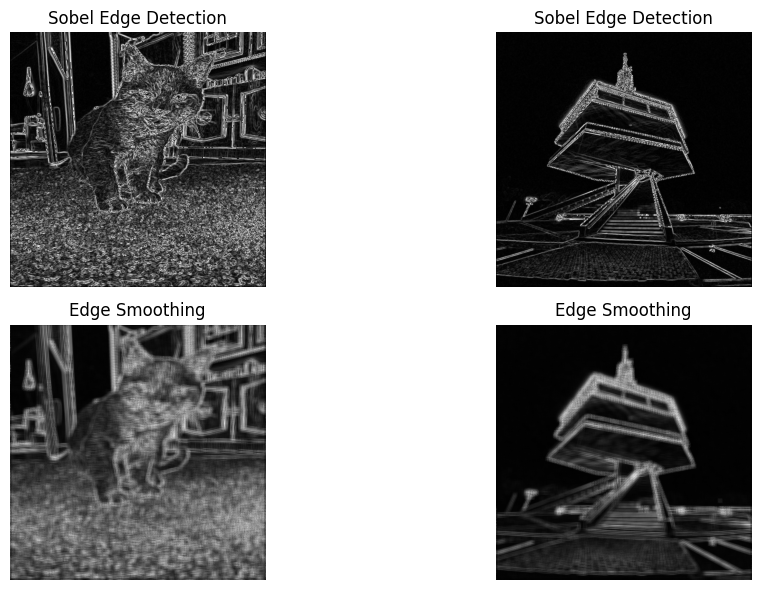

In [15]:
def main():
    # Load OpenCL kernel sources
    sobel_kernel_source = load_kernel_source('kernels/sobel.cl')
    smooth_kernel_source = load_kernel_source('kernels/smooth.cl')

    # Load input images
    input_image = load_image('media/cica.jpg')
    input_image2 = load_image('media/avas.jpg')

    # Rotate input images by -90 degrees
    input_image = rotate_image(input_image, -90)
    input_image2 = rotate_image(input_image2, -90)

    # Initialize OpenCL
    platform = cl.get_platforms()[0]
    device = platform.get_devices()[0]
    context = cl.Context([device])
    queue = cl.CommandQueue(context)

    # Create OpenCL programs for Sobel and edge smoothing kernels
    sobel_program = cl.Program(context, sobel_kernel_source).build()
    smooth_program = cl.Program(context, smooth_kernel_source).build()

    # Perform Sobel edge detection
    output_image = sobel_edge_detection(context, queue, input_image)
    output_image2 = sobel_edge_detection(context, queue, input_image2)

    # Perform edge smoothing
    smooth_output_image = edge_smoothing(context, queue, output_image)
    smooth_output_image2 = edge_smoothing(context, queue, output_image2)


    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.imshow(output_image, cmap='gray')
    plt.title('Sobel Edge Detection')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(output_image2, cmap='gray')
    plt.title('Sobel Edge Detection')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(smooth_output_image, cmap='gray')
    plt.title('Edge Smoothing')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(smooth_output_image2, cmap='gray')
    plt.title('Edge Smoothing')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
